# Main Simulation Loop Construction

Develop the main simulation loop for the formation model

01/05/2023

Andrew Weng

In [19]:
import os, sys

# Move the path up a level to be able to index into source files
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from src import plotter as plotter
from src import model as model

plotter.initialize(plt)

%matplotlib widget

# Configure the model parameters

In [20]:
# Global settings
vmax = 4.2

# Configure model parameters

# R-RC parameters
R0 = 0.082
R1 = 0.158
C1 = 38000
q_max_ah = 5 # Cell capacity in amp-hours

# eSOH parameters
Cn = 5 # Ah
Cp = 6 # Ah
theta_n_init = 0.0
theta_p_init = 1.0

# Simulation parameters
dt               = 1.0
sim_time_seconds = 10*3600 # Total simulation time
t_vec            = np.arange(0, sim_time_seconds, dt)

I_in = 0.5 # Amperes, positive is charge

theta_n_vec = model.initialize_sim_vec(t_vec, theta_n_init)
theta_p_vec = model.initialize_sim_vec(t_vec, theta_p_init)
ocv_n_vec   = model.initialize_sim_vec(t_vec, model.Un(theta_n_init))
ocv_p_vec   = model.initialize_sim_vec(t_vec, model.Up(theta_p_init))
vt_vec      = model.initialize_sim_vec(t_vec, ocv_p_vec[0] - ocv_n_vec[0])
ocv_vec     = model.initialize_sim_vec(t_vec, ocv_p_vec[0] - ocv_n_vec[0])
I_r1_vec    = model.initialize_sim_vec(t_vec, 0)


In [21]:
for k in range(0, len(t_vec) - 1):


    is_constant_voltage = vt_vec[k] == vmax

    # Constant current
    if not is_constant_voltage:

        dQ = I_in * dt / 3600 # Amp-hours    

        # Update stoichiometries
        theta_n_vec[k + 1] = theta_n_vec[k] + dQ / Cn
        theta_p_vec[k + 1] = theta_p_vec[k] - dQ / Cp 

        ocv_n_vec[k + 1] = model.Un(theta_n_vec[k + 1])
        ocv_p_vec[k + 1] = model.Up(theta_p_vec[k + 1])
        ocv_vec[k + 1]   = ocv_p_vec[k+1] - ocv_n_vec[k+1]

        I_r1_vec[k+1] =       np.exp(-dt/(R1*C1))  * I_r1_vec[k] + \
                         (1 - np.exp(-dt/(R1*C1))) * I_in

        vt_vec[k+1] = ocv_vec[k+1] + R1 * I_r1_vec[k] + R0 * I_in

        # Check for constant voltage condition
        if vt_vec[k+1] >= vmax:
           vt_vec[k+1] = vmax
        
    # Constant voltage
    else: 

        vt_vec[k+1] = vmax




    if k % 10 == 0:
        print(f'k = {k}, t = {t_vec[k]}s, ' +
              f'Un = {ocv_n_vec[k]:.4f}, Up = {ocv_p_vec[k]:.4f}, ' + 
              f'Vt = {vt_vec[k]:.5f}V ')


k = 0, t = 0.0s, Un = 0.9365, Up = 2.8186, Vt = 1.88209V 
k = 10, t = 10.0s, Un = 0.9212, Up = 2.8368, Vt = 1.95669V 
k = 20, t = 20.0s, Un = 0.9062, Up = 2.8545, Vt = 1.98954V 
k = 30, t = 30.0s, Un = 0.8915, Up = 2.8718, Vt = 2.02164V 
k = 40, t = 40.0s, Un = 0.8772, Up = 2.8887, Vt = 2.05302V 
k = 50, t = 50.0s, Un = 0.8631, Up = 2.9051, Vt = 2.08369V 
k = 60, t = 60.0s, Un = 0.8493, Up = 2.9212, Vt = 2.11367V 
k = 70, t = 70.0s, Un = 0.8358, Up = 2.9368, Vt = 2.14297V 
k = 80, t = 80.0s, Un = 0.8226, Up = 2.9521, Vt = 2.17161V 
k = 90, t = 90.0s, Un = 0.8096, Up = 2.9670, Vt = 2.19960V 
k = 100, t = 100.0s, Un = 0.7969, Up = 2.9816, Vt = 2.22696V 
k = 110, t = 110.0s, Un = 0.7845, Up = 2.9958, Vt = 2.25371V 
k = 120, t = 120.0s, Un = 0.7723, Up = 3.0096, Vt = 2.27985V 
k = 130, t = 130.0s, Un = 0.7604, Up = 3.0231, Vt = 2.30540V 
k = 140, t = 140.0s, Un = 0.7487, Up = 3.0363, Vt = 2.33038V 
k = 150, t = 150.0s, Un = 0.7373, Up = 3.0492, Vt = 2.35480V 
k = 160, t = 160.0s, Un = 0.72

# Visualize and save the results

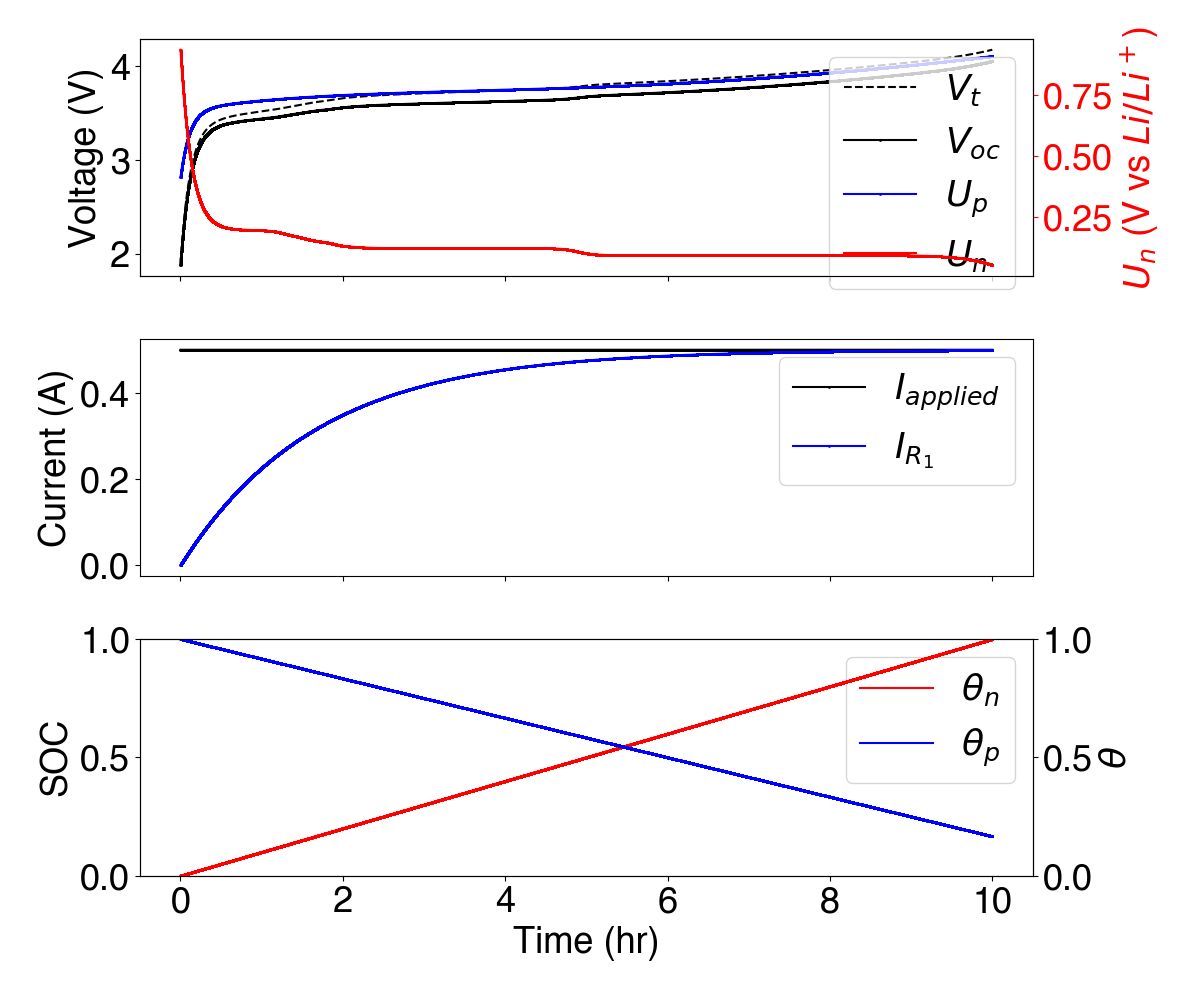

In [24]:

fig, axs = plt.subplots(3, figsize=(12, 10), sharex=True)

[ax.grid(False) for ax in axs]

# Voltages and Potentials
axs[0].plot(t_vec/3600, vt_vec,
            linestyle='--',
            color='k')
axs[0].plot(t_vec/3600, ocv_vec,
            marker='o', markersize=1,
            color='k')
axs[0].plot(t_vec/3600, ocv_p_vec,
            marker='o', markersize=1,
            color='b')
axs[0].plot(np.NaN, np.NaN, color='r') # dummy, for legend

ax_neg = axs[0].twinx()
ax_neg.grid(False)

ax_neg.plot(t_vec/3600, ocv_n_vec,
            marker='o', markersize=1,
            color='r')

ax_neg.tick_params(axis='y', colors='r')
ax_neg.set_ylabel('$U_n$ (V vs $Li/Li^+$)')
ax_neg.yaxis.label.set_color('red')

axs[0].set_ylabel('Voltage (V)')
axs[0].legend(['$V_t$', '$V_{oc}$', '$U_p$', '$U_n$'])

# Currents
axs[1].plot(t_vec/3600, np.ones(t_vec.shape)*I_in,
            color='k',
            marker='o', markersize=1)
axs[1].plot(t_vec/3600, I_r1_vec,
            color='b',
            marker='o', markersize=1)

axs[1].set_ylabel('Current (A)')
axs[1].legend(['$I_{applied}$', '$I_{R_1}$'])

# SOC and Lithium Stoichiometries
# axs[2].plot(t_vec/3600, z_vec,
            # marker='o', markersize=1,
            # color='k')

axs[2].plot(np.NaN, np.NaN, color='r') # dummy, for legend
axs[2].plot(np.NaN, np.NaN, color='b') # dummy

axs[2].set_xlabel('Time (hr)')
axs[2].set_ylim((0, 1))
axs[2].set_ylabel('SOC')

ax_stoic = axs[2].twinx()
ax_stoic.grid(False)

ax_stoic.plot(t_vec/3600, theta_n_vec,
              color='r',
              marker='o', markersize=1)

ax_stoic.plot(t_vec/3600, theta_p_vec,
              color='b',
              marker='o', markersize=1)

ax_stoic.set_ylabel(r'$\theta$')
ax_stoic.set_ylim((0, 1))
ax_neg.set_xlim(axs[0].get_xlim())

axs[2].legend([r'$\theta_n$', r'$\theta_p$'])

plt.tight_layout()
plt.show()
plt.savefig('outputs/figures/fig_formation_simulation.png', dpi=300)

